In [1]:
!pip install tensorflow

In [2]:
!pip install imblearn

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import collections

Once all the required libraries have been imported, the dataset is then uploaded

In [4]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [5]:
df = pd.read_csv('creditcard.csv')

The dataframe df is saved as the dataset, for EDA purposes

In [6]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.758743e-12,-8.252298e-13,-9.636929e-13,8.316157e-13,1.591952e-13,4.247354e-13,-3.050180e-13,8.693344e-14,-1.179712e-12,7.094854e-13,1.875015e-12,1.053488e-12,7.137527e-13,-1.491363e-13,-5.225914e-13,-2.280712e-13,-6.428517e-13,4.958987e-13,7.060712e-13,1.766038e-12,-3.406543e-13,-5.713163e-13,-9.725303e-13,1.464139e-12,-6.989087e-13,-5.615260e-13,3.332112e-12,-3.518886e-12,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Checking for null values in the dataset

In [8]:
df.isnull().sum().max()

0

Since there are no null values present, the EDA can now be performed. Firstly, the percentage of frauds vs non frauds in the dataset can be checked

In [9]:
print('No Fraud', round(df["Class"].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print("Fraud", round(df["Class"].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Fraud 99.83 % of the dataset
Fraud 0.17 % of the dataset


Approximately 0.17% of the dataset contains fraud values for the credit card info. This means that the original dataset is imbalanced, and using the original dataset would produce a lot of errors in the algorithms. 

However, detecting patterns in the dataset could give an indication of the signs of fraud in the credit card report.

Text(0.5, 1.0, 'Class Distribution \n (0: No Fraud || 1: Fraud)')

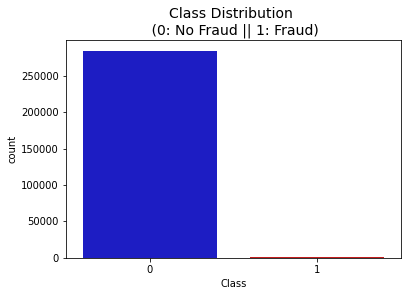

In [10]:
colors = ["#0101DF", "#DF0101"]

sns.countplot("Class", data = df, palette = colors)
plt.title("Class Distribution \n (0: No Fraud || 1: Fraud)", fontsize=14)

The features in the dataset are skewed.

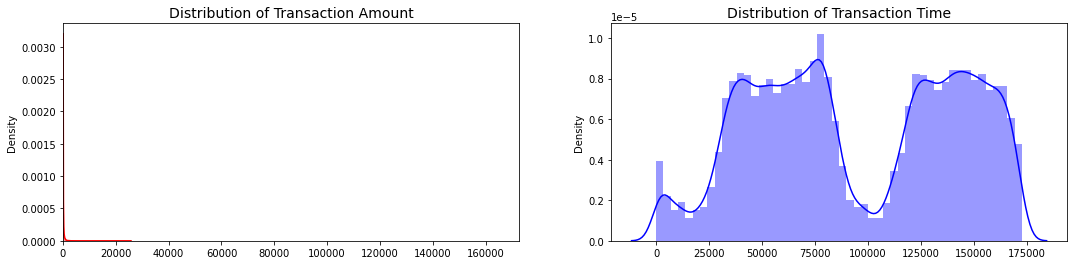

In [11]:
fig, ax=plt.subplots(1,2, figsize=(18,4))

amount_val = df["Amount"].values
time_val = df["Time"].values

sns.distplot(amount_val, ax = ax[0], color='r')
ax[0].set_title("Distribution of Transaction Amount", fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax= ax[1], color='b')
ax[1].set_title("Distribution of Transaction Time", fontsize=14)
ax[0].set_xlim([min(time_val), max(time_val)])

plt.show()

Based on the skewed dataset, the dataset will then be split 50-50 of fraud and non-fraud to have a balanced and equal amount of cases. Data splitting prevents overfitting of the dataset into ML algorithms and provides a better and more accurate correlation between variables.

In [12]:
# scaling Time and Amount
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers

std_scaler= StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [13]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [14]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

Adding scaled_amount and scaled_time into the columns of the dataframe df

In [15]:
df.drop(['scaled_amount','scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

Scaling the columns of Amount and Time:

In [17]:
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Now, the splitting of the dataset can occur

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Fraud', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# splitting the data
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X,y):
    print('Train:', train_index, 'Test:', test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    
    # we already have X_train and y_train in undersample data thats why i am using original to distinguish
    # original_Xtrain,original_Xtest,original_ytrain,original_ytest = train_test_split(X,y test_size=0.3, random_state=100)
    
    # Check the distribution and turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# see if the train and test label are distributed similarly
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distribution \n')
print(train_counts_label/len(original_ytrain))
print(test_counts_label/len(original_ytest))

No Frauds 99.83 % of the dataset
Fraud 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distribution 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


Next, Random is implemented into the dataframe. This would remove the data so that a more balanced dataset is produced (preventing overfitting).

Moreover, using value_counts determines how imbalanced the dataset is.

Next, determinining how many instances are considered fraud transactions and bring the non-fraud transaction to the same amount can be performed.

In [19]:
df = df.sample(frac=1)

The dataset above is shuffled before the sub-samples are created.

In [20]:
# amount of fraud classes 492 rows
fraudu = df.loc[df['Class'] ==1]
non_fraudu = df.loc[df['Class'] ==0][:492]

In [21]:
normal_distributed_df = pd.concat([fraudu, non_fraudu])

The dataframe rows are shuffled, and now, a new dataset called "New" is procured

In [22]:
New = normal_distributed_df.sample(frac=1, random_state=42)

New.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
72598,1.998183,-0.351484,-0.711983,0.347217,1.096351,0.196503,0.769888,0.516908,1.608537,-0.225637,-0.246148,-0.724634,-1.270751,0.485867,1.080346,-0.541051,-0.823222,-0.431330,-0.496938,-0.714220,-0.667434,0.316431,0.020989,0.161521,0.056325,-0.758095,0.165929,-0.509000,-0.066323,-0.077595,0
231978,-0.195626,0.731987,-2.064240,2.629739,-0.748406,0.694992,0.418178,1.392520,-1.697801,-6.333065,1.724184,-0.887242,-1.594258,-0.338775,-0.978065,-3.688826,-1.487083,0.526946,2.347023,1.691220,-0.736111,-1.424486,6.215514,-1.276909,0.459861,-1.051685,0.209178,-0.319859,0.015434,-0.050117,1
214666,0.942919,0.647047,1.944001,0.079008,-2.600456,1.236501,1.021716,-1.078739,1.090092,-0.486938,-0.142398,0.372285,-1.153713,-0.487856,-1.251903,1.120755,-0.119054,-0.796996,-0.167369,-0.336310,-0.321565,-0.170454,0.335068,0.894207,-0.261058,0.628361,0.834477,-0.224075,-0.078887,-0.060740,0
250761,-0.296653,0.826631,-0.512349,4.827060,-7.973939,7.334059,0.367704,-2.055129,-2.935856,1.431008,-4.544722,-5.258096,5.716319,-5.810407,0.723293,-12.289133,0.378773,-2.020734,-2.039703,0.658183,0.832574,0.804101,0.535620,-0.459496,-0.009364,-1.140436,-0.006445,0.527970,0.558881,0.126517,1
89190,19.285405,-0.261105,-5.344665,-0.285760,-3.835616,5.337048,-7.609909,3.874668,1.289630,0.201742,-3.003532,-3.990551,4.986014,-6.116383,0.042324,-6.043393,1.821401,-4.745462,-10.075646,-3.604596,1.435294,-1.562162,0.276011,1.342045,-1.016579,-0.071361,-0.335869,0.441044,1.520613,-1.115937,1


The dataset is now correctly balanced. Hence, data pre-processing can now be performed.

Distribution of the classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


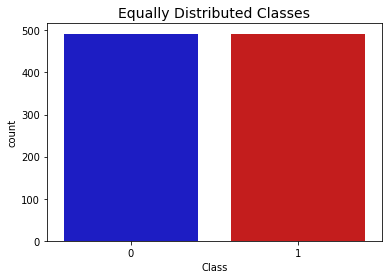

In [23]:
print('Distribution of the classes in the subsample dataset')
print(New['Class'].value_counts()/len(New))


sns.countplot('Class', data=New, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Using a correlation matrix, the correlation between each variables in the dataset can be found

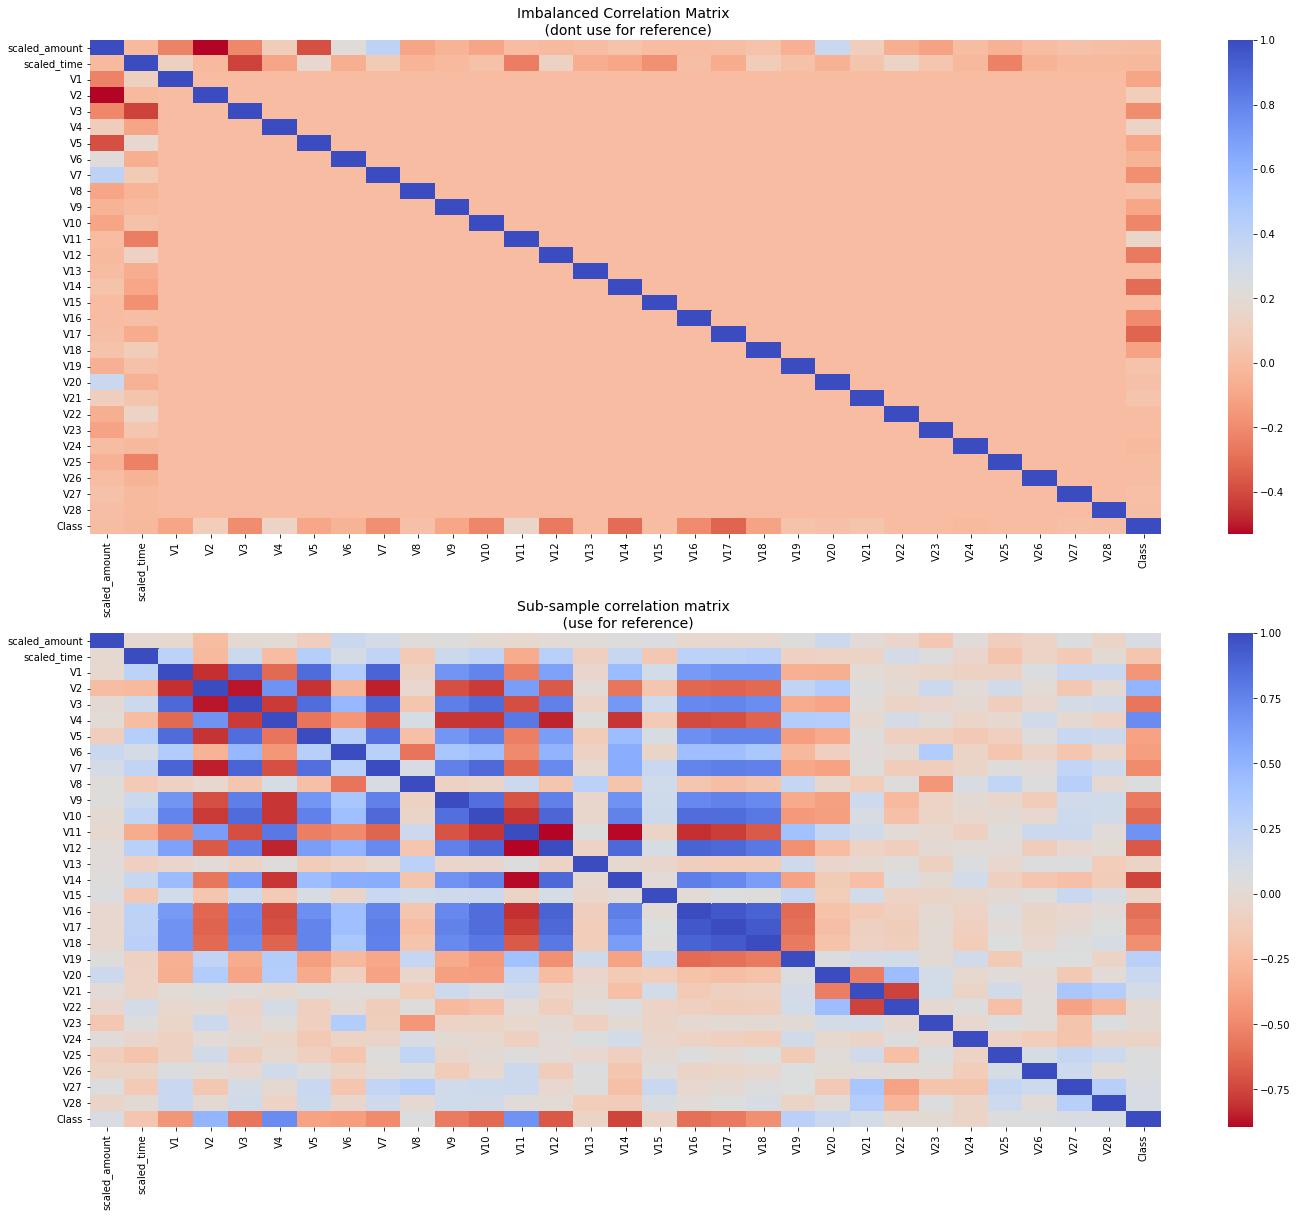

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire dataframe
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (dont use for reference)", fontsize=14)

sub_sample_corr = New.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("Sub-sample correlation matrix \n (use for reference)", fontsize=14)

plt.show()

Analysis using boxplot is perforemd on the Negative correlations in the dataset

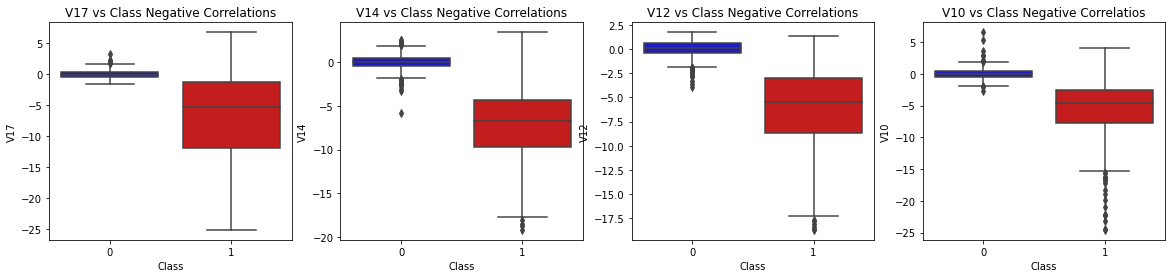

In [28]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negatively correlated with our class (the lower it is the more likely its a fraud)
sns.boxplot(x="Class", y="V17", data=New, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlations')

sns.boxplot(x='Class', y='V14', data=New, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlations')

sns.boxplot(x='Class', y='V12', data=New, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlations')

sns.boxplot(x='Class', y='V10', data=New, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlatios')

plt.show()

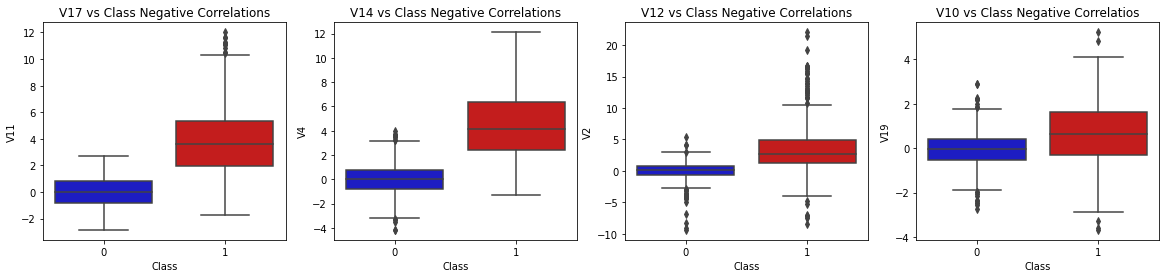

In [29]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negatively correlated with our class (the lower it is the more likely its a fraud)
sns.boxplot(x="Class", y="V11", data=New, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlations')

sns.boxplot(x='Class', y='V4', data=New, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlations')

sns.boxplot(x='Class', y='V2', data=New, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlations')

sns.boxplot(x='Class', y='V19', data=New, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlatios')

plt.show()

Next, detection of anomalies or outliers are performed. Extreme outliers are removed

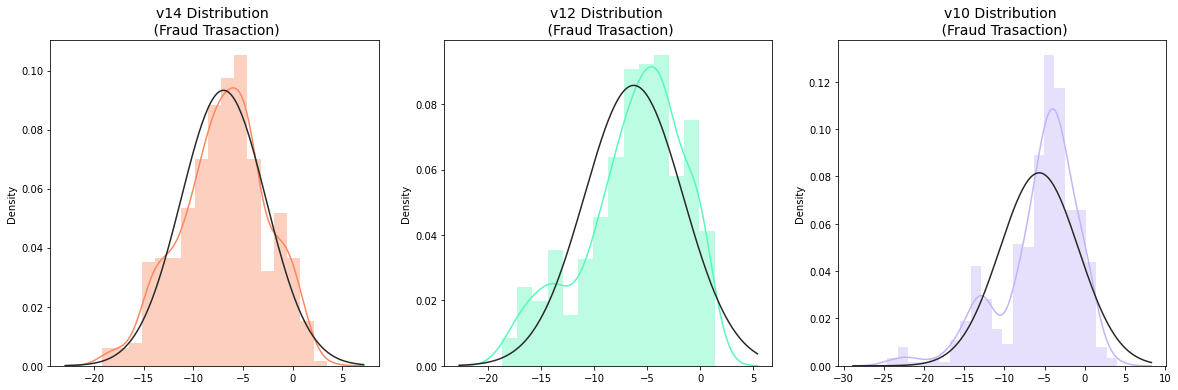

In [30]:
from scipy.stats import norm

f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = New['V14'].loc[New['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('v14 Distribution \n (Fraud Trasaction)', fontsize=14)

v12_fraud_dist = New['V12'].loc[New['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('v12 Distribution \n (Fraud Trasaction)', fontsize=14)

v10_fraud_dist = New['V10'].loc[New['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('v10 Distribution \n (Fraud Trasaction)', fontsize=14)

plt.show()

In [31]:
# v14 removiing outliers(highest negatively correlated with labels)
v14_fraud = New['V14'].loc[New['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
# determining the interquartile Range (IQR)
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

# Determining the Treshold
v14_cut_off = v14_iqr * 1.5

# determing the upper and lower treshold
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}.'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

# condition dropping stating if the treshold is exceed in both extrems the instance would be removed
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 Outliers: {}'.format(outliers))

New = New.drop(New[(New['V14'] > v14_upper) | (New['V14'] < v14_lower)].index)
print('----' * 44)


# V12 removing outliers from fraud
v12_fraud = New['V12'].loc[New['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5

v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v14_upper]
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V12 Outliers: {}'.format(outliers))

New = New.drop(New[(New['V12'] > v12_upper) | (New['V12'] < v12_lower)].index)
print('----' * 44)

# V10 removing outliers form fraud
v10_fraud = New['V10'].loc[New['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5

v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 Outliers: {}'.format(outliers))

New = New.drop(New[(New['V10'] > v10_upper) | (New['V10'] < v10_lower)].index)
print('----' * 44)

Quartile 25: -9.69272296475 | Quartile 75: -4.2828208495
iqr: 5.40990211525
Cut Off: 8.114853172875002
V14 Lower: -17.807576137625002.
V14 Upper: 3.8320323233750013
Feature V14 Outliers for Fraud Cases: 4
V14 Outliers: [-18.49377336, -18.04999769, -18.82208674, -19.21432549]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -8.6730332045 | Quartile 75: -2.8930305682500004
V12 Lower: -17.343037158875
V12 Upper: 5.776973386124998
Feature V12 Outliers for Fraud Cases: 4
V12 Outliers: [-18.68371463, -18.43113103, -18.04759657, -18.55369701]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -7.466658536000001 | Quartile 75: -2.51186113825
V10 Lower: -14.898854632625003
V10 Upper: 4.920334958375001
Feature V10 Outlie

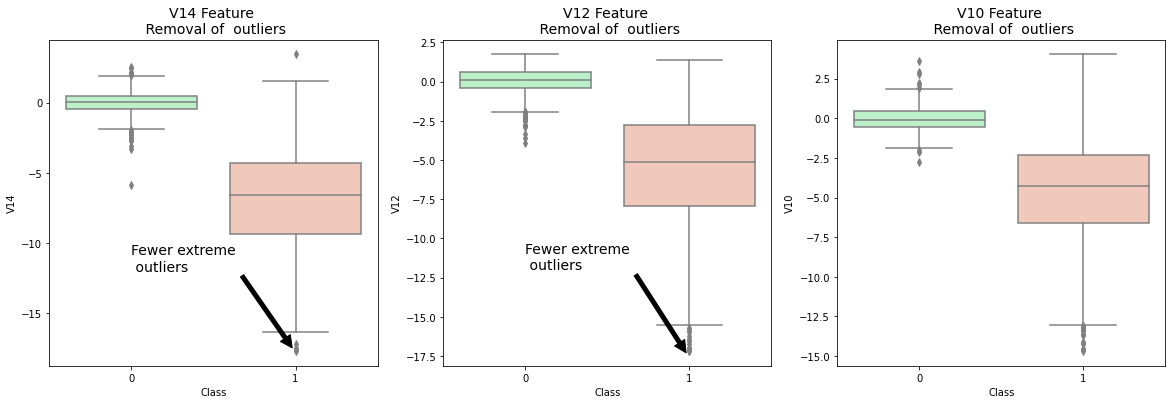

In [32]:
f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Creating the boxplot with removed outliers

# feature v14
sns.boxplot(x="Class", y="V14", data=New, ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Removal of  outliers", fontsize=14)
ax1.annotate("Fewer extreme \n outliers", xy=(0.98, -17.5), xytext=(0, -12),arrowprops=dict(facecolor="black"), fontsize=14)

# feature v12
sns.boxplot(x="Class", y="V12", data=New, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Removal of  outliers", fontsize=14)
ax2.annotate("Fewer extreme \n outliers", xy=(0.98, -17.3), xytext=(0, -12),arrowprops=dict(facecolor="black"), fontsize=14)

# feature v10
sns.boxplot(x="Class", y="V10", data=New, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Removal of  outliers", fontsize=14)
ax3.annotate("Fewer extreme \n outliers", xy=(0.95, -16.5), xytext=(0, -12),arrowprops=dict(facecolor="black"), fontsize=14)

plt.show()

Using t-SNE algorithms in the dataset is pivotal in clustering the dataset into cases that were fraud and non-fraud

In [33]:
X = New.drop('Class', axis=1)
y = New['Class']


# T-SNE implementation
t0 = time.time()
X_reduced_tsne =TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1-t0))

# PCA implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1= time.time()
print("PCA took {:.2} s".format(t1-t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized' ,random_state=42).fit_transform(X.values)
t1 = time.time()
print("SVD took {:.2} s".format(t1-t0))

T-SNE took 1.1e+01 s
PCA took 0.042 s
SVD took 0.0072 s


Next, plots are shown to show how well the clustering is performed in the dataset

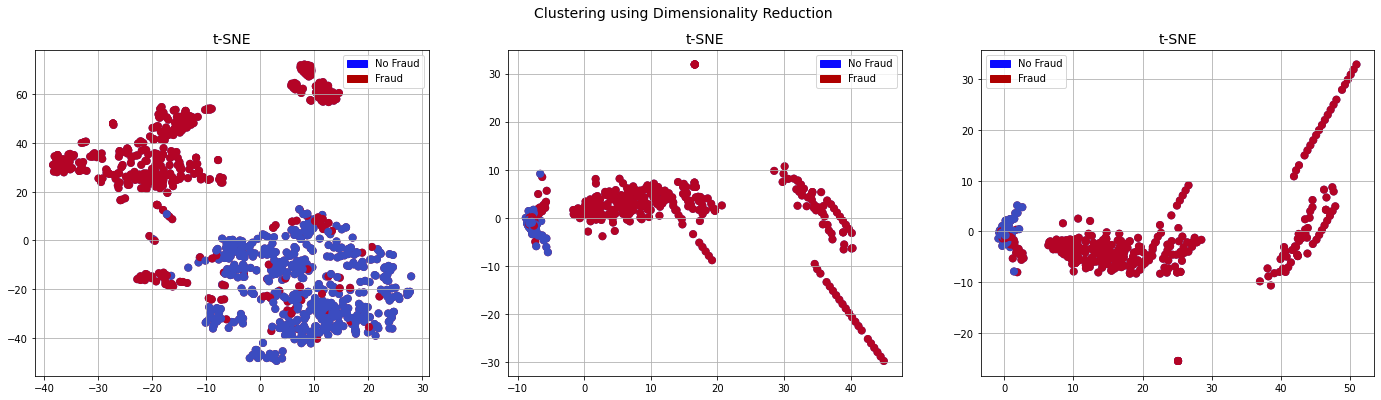

In [34]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(24,6))
# labels = ['No-Fraud', 'Fraud']
f.suptitle("Clustering using Dimensionality Reduction", fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label="No Fraud")
red_patch = mpatches.Patch(color='#AF0000', label="Fraud")


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap="coolwarm", label="No Fraud", linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap="coolwarm", label="Fraud", linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch,red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap="coolwarm", label="No Fraud", linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap="coolwarm", label="Fraud", linewidths=2)
ax2.set_title('t-SNE', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch,red_patch])

# TruncatedSVD Scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap="coolwarm", label="No Fraud", linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap="coolwarm", label="Fraud", linewidths=2)
ax3.set_title('t-SNE', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch,red_patch])

plt.show()

Next, using Classifier to decide which classification can detect Fraud transactions.

Firslty, the dataset is split into training and testing datasets.

The code below is used to under-sample dataset before cross-validation

In [35]:
X = New.drop('Class', axis=1)
y = New['Class']

The dataset is now split into testing and training

In [36]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.30, random_state=42, )

The values are turned into arrays, to feed into the classification algorithm

In [37]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Applying simple classifiers:

In [38]:
classifiers = {"LogisticRegression": LogisticRegression(),
              "KNearest": KNeighborsClassifier(),
              "Support Vector Classifier": SVC(),
              "DecisionTreeClassifier": DecisionTreeClassifier()}

In [39]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) *
         100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 94.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


Gridsearch CV can be used to find the optimum parameter in the dataset

In [40]:
from sklearn.model_selection import GridSearchCV

# For logistics Regression'
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train,y_train)

# we get the best fit
log_reg = grid_log_reg.best_estimator_

# for Knearest Neighbor
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm':['auto','ball_tree','kd_tree','brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

# best fit
knears_neighbors = grid_knears.best_estimator_

# for Support vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# best fit
svc = grid_svc.best_estimator_

# for Decision Tree
tree_params = {"criterion": ['gini','entropy'], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# best fit
tree_clf = grid_tree.best_estimator_

In [41]:
# overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + "%")

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score:', round(knears_score.mean() * 100, 2).astype(str) + "%")

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier :', round(svc_score.mean() * 100, 2).astype(str) + "%")

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('Decision Tree Classifier :', round(tree_score.mean() * 100, 2).astype(str) + "%")

Logistic Regression Cross Validation Score:  93.5%
Knears Neighbors Cross Validation Score: 93.35%
Support Vector Classifier : 93.35%
Decision Tree Classifier : 93.5%


Now, under-sampling can be carried out for Cross Validation

In [42]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
# converting to array
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# implementation of the NearMiss Technique
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# now cross validating the right way
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    # SMOTE happens during Cross validation not before
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))
    

Train: [ 56953  56954  56955 ... 284804 284805 284806] Test: [    0     1     2 ... 59739 59790 59793]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56953  56954  56955 ... 115324 115996 116484]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113918 113919 113920 ... 170884 170885 170886]
Train: [     0      1      2 ... 284804 284805 284806] Test: [169343 169828 170887 ... 228288 228838 228923]
Train: [     0      1      2 ... 228288 228838 228923] Test: [227841 227842 227843 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


Learning curves can be plotted for the classifiers using Logistic Regression

In [43]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X,y, ylim=None, cv=None, n_jobs=1,
                       train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
        
        # First estimator
        train_sizes, train_scores, test_scores = learning_curve(estimator1, X,y, cv=cv, n_jobs=n_jobs,
                                                                train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean+train_scores_std,
                        alpha=0.1, color = "#ff9124")
        ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                        alpha=0.1, color= "#2492ff")
        ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training Score")
        ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
        ax1.set_title("Logistic Regression Learnining Curve", fontsize=14)
        ax1.set_xlabel('Training Size (m)')
        ax1.set_ylabel('Score')
        ax1.grid(True)
        ax1.legend(loc="best")
        
        # Second Estimator
        train_sizes, train_scores, test_scores = learning_curve(estimator2, X,y, cv=cv, n_jobs=n_jobs,
                                                                train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax2.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean+train_scores_std,
                        alpha=0.1, color = "#ff9124")
        ax2.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                        alpha=0.1, color= "#2492ff")
        ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training Score")
        ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
        ax2.set_title("Knears Neighbors Learnining Curve", fontsize=14)
        ax2.set_xlabel('Training Size (m)')
        ax2.set_ylabel('Score')
        ax2.grid(True)
        ax2.legend(loc="best")
        
        # third estimator
        train_sizes, train_scores, test_scores = learning_curve(estimator3, X,y, cv=cv, n_jobs=n_jobs,
                                                                train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax3.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean+train_scores_std,
                        alpha=0.1, color = "#ff9124")
        ax3.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                        alpha=0.1, color= "#2492ff")
        ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training Score")
        ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
        ax3.set_title("Support Vector Classifier Learnining Curve", fontsize=14)
        ax3.set_xlabel('Training Size (m)')
        ax3.set_ylabel('Score')
        ax3.grid(True)
        ax3.legend(loc="best")
        
        # Fourth Estimator
        train_sizes, train_scores, test_scores = learning_curve(estimator4, X,y, cv=cv, n_jobs=n_jobs,
                                                                train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean+train_scores_std,
                        alpha=0.1, color = "#ff9124")
        ax4.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                        alpha=0.1, color= "#2492ff")
        ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training Score")
        ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
        ax4.set_title("Decision Tree Learnining Curve", fontsize=14)
        ax4.set_xlabel('Training Size (m)')
        ax4.set_ylabel('Score')
        ax4.grid(True)
        ax4.legend(loc="best")
        return plt
        

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

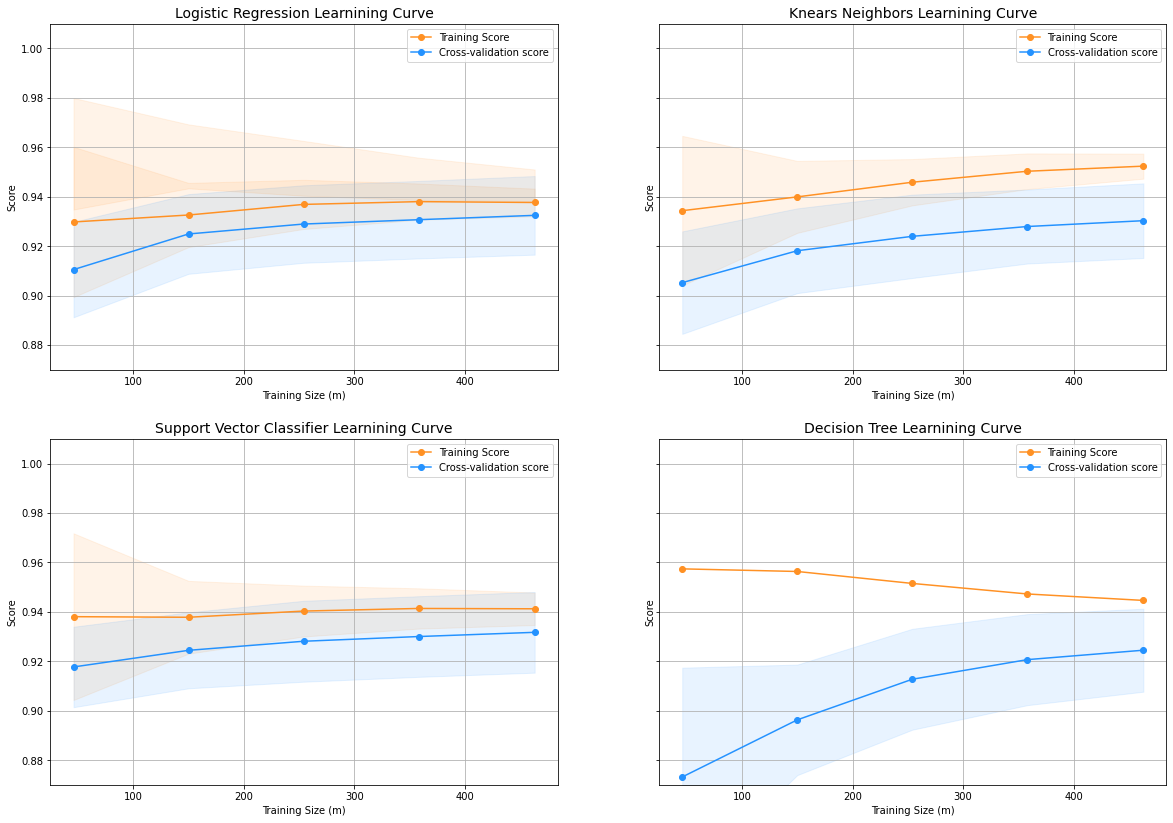

In [44]:
cv = ShuffleSplit(n_splits=100, test_size=0.30, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf,
                   X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [45]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

A dataframe is created with all the scores and classifier names

In [46]:
log_reg_pred = cross_val_predict(log_reg, X_train, y_train,
                                cv=5, method = "decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train,
                                cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train,
                             cv=5, method="decision_function")
tree_pred = cross_val_predict(tree_clf, X_train, y_train,
                              cv = 5)

In [47]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression:', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors:', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier:', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier:', roc_auc_score(y_train, tree_pred))

Logistic Regression: 0.978594614364742
KNears Neighbors: 0.9307273807891008
Support Vector Classifier: 0.9801856169706945
Decision Tree Classifier: 0.9329447263749828


All the classifier scores provide more than 93% accuracy

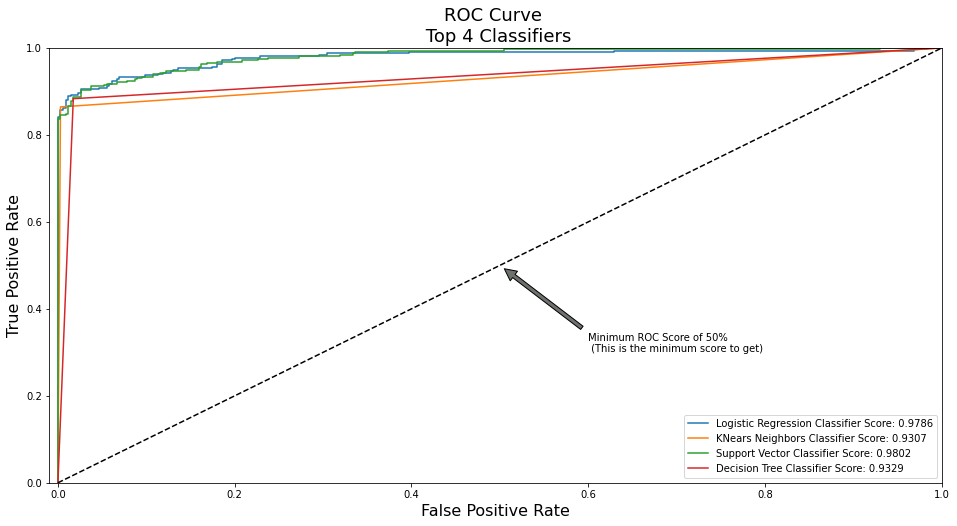

In [48]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

Next, using Logistic Regression classifiers:

. True Positives : Correctly classified Fraud Transactions
. False Positives : Incorrectly classified Fraud Transactions

. True Negatives: Correctly classified Non-fraud Transactions
. False Negatives: incorrectly classifed Non-fraud Transactions

. Precision : True Positives/(true positives + false positives)

. Recall : is the amount of fraud cases the model is able to detect. A high recall score is important

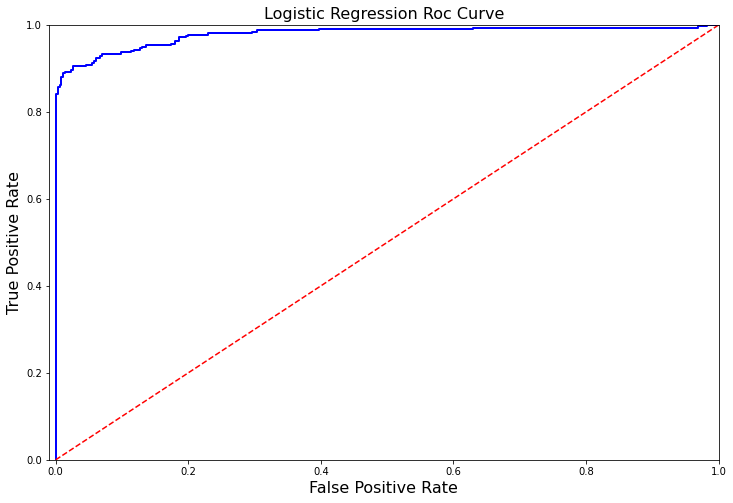

In [49]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression Roc Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [50]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [54]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('Target score:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.88
Precision Score: 0.96
F1 Score: 0.92
Accuracy Score: 0.92
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
Target score:

Accuracy Score: 0.94
Precision Score: 0.00
Recall Score: 0.05
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [52]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [53]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.15


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.15')

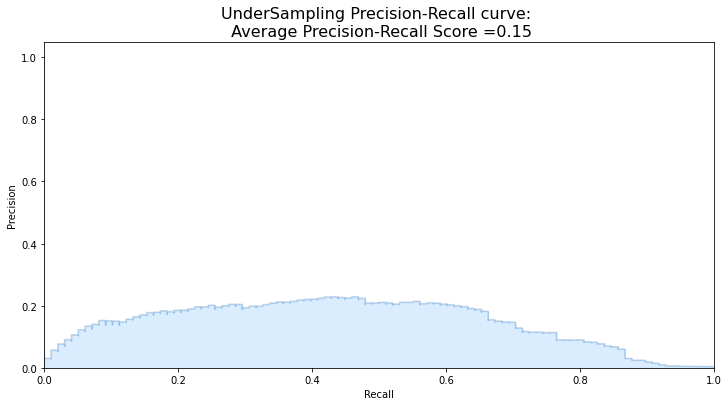

In [55]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

Next, using SMOTE (Synthetic Minority Over-sampling Techinque) creates new synthetic points to have an equal balance of classes in the dataset. 

This is an alternative in solving imbalance datasets 

In [56]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9432166775925677
precision: 0.06168281660599688
recall: 0.9137293086660175
f1: 0.11368901677634366
---------------------------------------------------------------------------------------------------------------------------------------


In [57]:
y_score = best_est.decision_function(original_Xtest)

In [58]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.75


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.75')

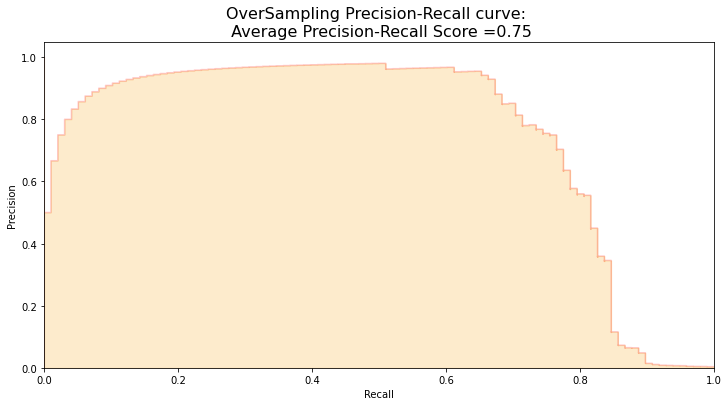

In [59]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

SMOTE Technique (OverSampling) After splitting and Cross Validating

In [60]:
sm = SMOTE(random_state=42, sampling_strategy=0.6)

Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

The score can be improved by approximately 2%

In [61]:
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :6.286086797714233 sec


Confusion Matrix positive/Negative: Type of class (label) ["No","yes"]True/False: correctly of incorrectly classified by the model TrueNegatives(Top-Left Square): Number of correctly classified No-fraud class

False Negatives (Top-Right Square): This is the number of incorrectly classifications of the "No"(No Fraud Detected) class.

False Positives (Bottom-Left Square): This is the number of incorrectly classifications of the "Yes" (Fraud Detected) class

True Positives (Bottom-Right Square): This is the number of correctly classifications of the "Yes" (Fraud Detected) class.

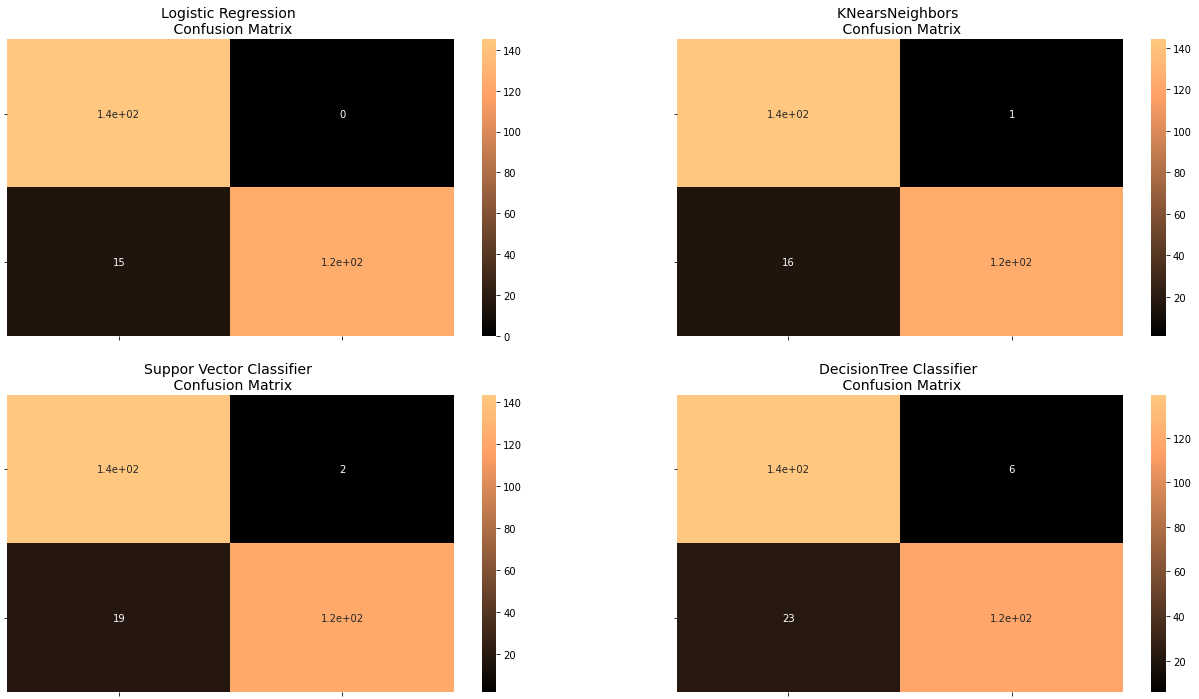

In [62]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [63]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       145
           1       1.00      0.89      0.94       140

    accuracy                           0.95       285
   macro avg       0.95      0.95      0.95       285
weighted avg       0.95      0.95      0.95       285

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       145
           1       0.99      0.89      0.94       140

    accuracy                           0.94       285
   macro avg       0.95      0.94      0.94       285
weighted avg       0.95      0.94      0.94       285

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       145
           1       0.98      0.86      0.92       140

    accuracy                           0.93       285
   macro avg       0.93      0.93      0.93       285
weighted

The scores based on the classifications above are good, with a high precision, recall and f1-score

Next, using a final score test using Logistic Regression:

In [64]:
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.947368
1,Oversampling (SMOTE),0.988202


The scores for both under and oversampling are high!

References:

A big help from the following Kaggle notebook, to clearly explain each code with reasons for using them:

https://www.kaggle.com/darkpsycs/detecting-credit-card-fraud